In [1]:
# Load all relevant modules
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time as timer
import math

In [2]:
# Constants
DATADIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data')

In [3]:
def create_batch(x, y, batch_size=32):
    n  = x.shape[0] # number of data
    batches = [] 
    batch_num = math.floor(n / batch_size)
    # print(f"batch num: {batch_num}")

    for i in range(batch_num):
        x_batch = x[i * batch_size:(i+1) * batch_size, :]
        y_batch = y[i * batch_size:(i+1) * batch_size]
        batches.append((x_batch, y_batch))

    if n % batch_size != 0:
        x_batch = x[batch_num * batch_size:, :]
        y_batch = y[batch_num * batch_size:]
        batches.append((x_batch, y_batch))
    
    return batches

In [4]:
class LogisticClassifier:
    def __init__(self, dim=1):
        self.step_size = None
        self.l2reg = None
        self.w = None
        self.eps = 1e-20
        self.dim = dim
        
        self.initialize_weights()
    
    def initialize_weights(self):
        self.w = np.random.normal(0, 0.1, (self.dim+1, ))
        self.w[0] = 0.

    def sigmoid(self, z):
        return 1 / (1 + np.exp((-z + self.eps)) + self.eps)

    def model_fn(self, X):
        return self.sigmoid(X @ self.w)
    
    def loss_fn(self, y, prob_hat, mode='mean'):
        if mode == 'sum':
            loss = -np.sum((y * np.log(prob_hat + self.eps) + (1 - y) * np.log(1 - prob_hat + self.eps)))
            loss += self.l2reg * len(y) * np.linalg.norm(self.w) ** 2
        else:
            loss = -np.mean((y * np.log(prob_hat + self.eps) + (1 - y) * np.log(1 - prob_hat + self.eps)))
            loss += self.l2reg * np.linalg.norm(self.w) ** 2
        return loss
    
    def grad_loss_fn(self, X, y, prob_hat):
        n = X.shape[0]
        g = ((prob_hat - y) @ X) / n
        g += self.l2reg * self.w
        return g
    

    def accuracy_fn(self, y, prob_hat):
        # print(f'[accuracy_fn] y: {y}, prob_hat: {prob_hat}')
        y_hat = np.round(prob_hat)
        acc = np.sum(y == y_hat)
        return acc / len(y)

    def train_on_step(self, X, y):
        """
        Args:
            X (nd.array): n x d
            y
        """
        Xb = np.insert(X, 0, 1, axis=1) # add 1s for bias term
        yb = y

        # Forward pass
        probb_hat = self.model_fn(Xb)
        loss_values = self.loss_fn(yb, probb_hat)
        
        # Backward pass: gradient update
        g = self.grad_loss_fn(Xb, yb, probb_hat)
        self.w -= self.step_size * g
        # print(f"[train_on_step] w: {self.w}")

        return loss_values

    def transform(self, X):
        Xb = np.insert(X, 0, 1, axis=1) # add 1s for bias 
        prob_hat = self.model_fn(Xb)
        return prob_hat
    
    def fit(self, X, y, epochs=1, batch_size=32, step_size=1e-7, l2reg=0):
        self.step_size = step_size
        self.l2reg = l2reg
        batches = create_batch(X, y, batch_size=batch_size)
        num_batches = len(batches)
        
        losses = []
        accuracies = []
        elapsed_times = []
        for ep in range(epochs):
            loss_avg = 0.
            start_t = timer.time()
            for b, (X_batch, y_batch) in enumerate(batches):
                # Train on step or batch
                l = self.train_on_step(X_batch, y_batch)
                # print(f"[train on step] l : {l}")
                loss_avg += l
            # end for batch
            elapsed_t = timer.time() - start_t
            elapsed_times.append(elapsed_t)

            loss_avg /= num_batches
            losses.append(loss_avg)

            # compute accuracy
            prob_hat = self.transform(X)
            acc = self.accuracy_fn(y, prob_hat)
            accuracies.append(acc)

            print(f"Epoch-{ep+1}: loss: {loss_avg:.3f}, acc: {100 * acc:.2f}, elapsed time: {elapsed_t: .4f} secs")
        # enf for epoch

        return losses, accuracies, elapsed_times

In [5]:
# Load dataset
datapath = os.path.join(DATADIR, 'Healthcare-Diabetes.csv')

df = pd.read_csv(datapath)
df

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...,...
2763,2764,2,75,64,24,55,29.7,0.370,33,0
2764,2765,8,179,72,42,130,32.7,0.719,36,1
2765,2766,6,85,78,0,0,31.2,0.382,42,0
2766,2767,0,129,110,46,130,67.1,0.319,26,1


In [6]:
# Get features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
print(X.shape, X)
print(y.shape, y)

n = X.shape[0] # total samples

(2768, 9) [[1.000e+00 6.000e+00 1.480e+02 ... 3.360e+01 6.270e-01 5.000e+01]
 [2.000e+00 1.000e+00 8.500e+01 ... 2.660e+01 3.510e-01 3.100e+01]
 [3.000e+00 8.000e+00 1.830e+02 ... 2.330e+01 6.720e-01 3.200e+01]
 ...
 [2.766e+03 6.000e+00 8.500e+01 ... 3.120e+01 3.820e-01 4.200e+01]
 [2.767e+03 0.000e+00 1.290e+02 ... 6.710e+01 3.190e-01 2.600e+01]
 [2.768e+03 2.000e+00 8.100e+01 ... 3.010e+01 5.470e-01 2.500e+01]]
(2768,) [1 0 1 ... 0 1 0]


In [7]:
# Split dataset into train and validation sets
n_train = int(0.7 * n)
n_val = n - n_train
print(n_train, n_val)

X_train = X[:n_train, :]
y_train = y[:n_train]

X_val = X[n_train:, :]
y_val = y[n_train:]

1937 831


### Define model

In [17]:
d = X_train.shape[1]
LC = LogisticClassifier(dim=d)

In [18]:
# Check accuracy before training
prob_train_hat = LC.transform(X_train)
prob_val_hat = LC.transform(X_val)

train_acc = LC.accuracy_fn(y_train, prob_train_hat)
val_acc = LC.accuracy_fn(y_val, prob_val_hat)
print(f"Train accuracy: {train_acc:.2f}, Validation accuracy: {val_acc:.2f}")

Train accuracy: 0.34, Validation accuracy: 0.35


### Train!

In [19]:
epochs = 400
batch_size = 64
step_size = 1e-6 # learning rate
l2reg = 1e-2 #l2 reg coefficient
losses, accuracies, elapsed_times = LC.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    step_size=step_size,
    l2reg=l2reg
)

Epoch-1: loss: 29.345, acc: 33.97, elapsed time:  0.0022 secs
Epoch-2: loss: 28.996, acc: 33.97, elapsed time:  0.0009 secs
Epoch-3: loss: 28.225, acc: 33.97, elapsed time:  0.0007 secs
Epoch-4: loss: 21.456, acc: 34.02, elapsed time:  0.0008 secs
Epoch-5: loss: 9.222, acc: 46.62, elapsed time:  0.0007 secs
Epoch-6: loss: 5.756, acc: 51.68, elapsed time:  0.0007 secs
Epoch-7: loss: 5.307, acc: 53.54, elapsed time:  0.0007 secs
Epoch-8: loss: 5.172, acc: 54.16, elapsed time:  0.0007 secs
Epoch-9: loss: 5.100, acc: 54.47, elapsed time:  0.0007 secs
Epoch-10: loss: 5.042, acc: 54.62, elapsed time:  0.0007 secs
Epoch-11: loss: 4.991, acc: 54.72, elapsed time:  0.0007 secs
Epoch-12: loss: 4.947, acc: 54.78, elapsed time:  0.0007 secs
Epoch-13: loss: 4.899, acc: 54.78, elapsed time:  0.0007 secs
Epoch-14: loss: 4.856, acc: 54.83, elapsed time:  0.0007 secs
Epoch-15: loss: 4.809, acc: 54.72, elapsed time:  0.0007 secs
Epoch-16: loss: 4.767, acc: 54.52, elapsed time:  0.0007 secs
Epoch-17: los

In [11]:
# Check accuracy after training
prob_train_hat = LC.transform(X_train)
prob_val_hat = LC.transform(X_val)

train_acc = LC.accuracy_fn(y_train, prob_train_hat)
val_acc = LC.accuracy_fn(y_val, prob_val_hat)
print(f"Train accuracy: {train_acc:.2f}, Validation accuracy: {val_acc:.2f}, Elapsed times: {sum(elapsed_times)} secs")

Train accuracy: 0.64, Validation accuracy: 0.67, Elapsed times: 0.544316291809082 secs


norm(w): 0.16420803359073105


<BarContainer object of 10 artists>

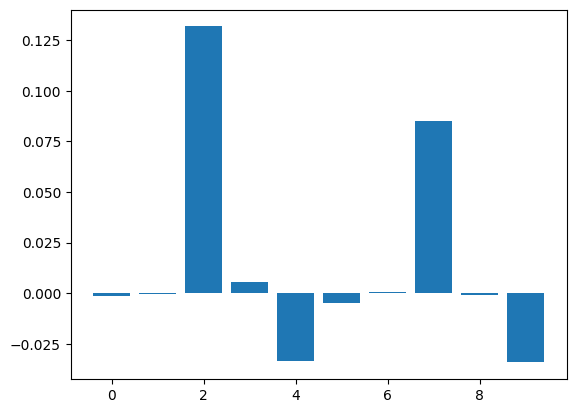

In [12]:
# Show weights
print(f"norm(w): {np.linalg.norm(LC.w)}")
plt.bar(np.arange(len(LC.w)), LC.w)

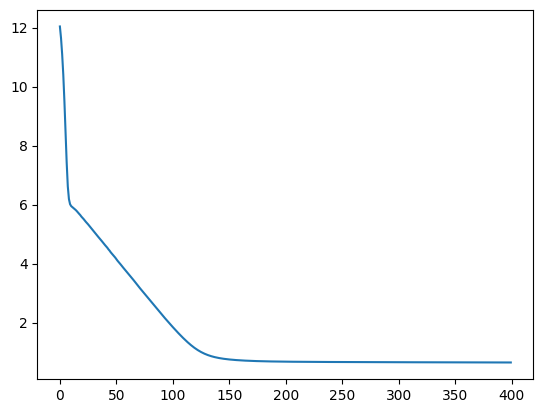

In [13]:
plt.plot(range(len(losses)), losses)

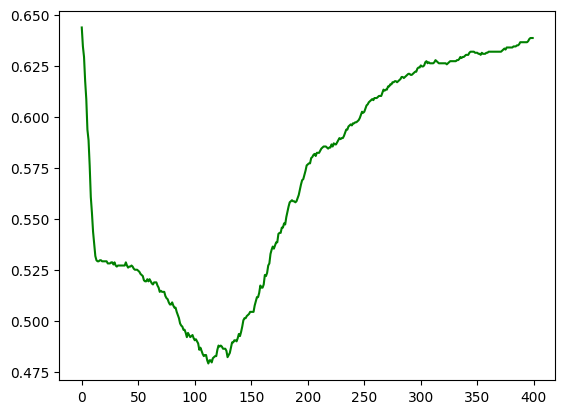

In [14]:
plt.plot(range(len(accuracies)), accuracies, color='green')

### Logistic Regression with Scikit Learn

In [34]:
from sklearn.linear_model import LogisticRegression

In [37]:
clf = LogisticRegression(random_state=0)

In [38]:
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [39]:
# calculate accuracy after training
y_train_hat = clf.predict(X_train)
y_val_hat = clf.predict(X_val)
train_acc = np.sum(y_train == y_train_hat) / len(y_train)
val_acc = np.sum(y_val == y_val_hat) / len(y_val)
print(f"[sklearn] train accuracy: {train_acc:.2f}, validation accuracy: {val_acc:.2f}")

[sklearn] train accuracy: 0.70, validation accuracy: 0.67
